In [1]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import os
import cv2 as cv


import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split



2025-05-13 13:34:28.618410: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-13 13:34:29.239543: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-13 13:34:29.242411: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-13 13:34:31.145080: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [20]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.25
)

train_generator = datagen.flow_from_directory(
    'data/train',
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary',
    shuffle=True,
    subset='training',
)

val_generator = datagen.flow_from_directory(
    'data/train',
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary',
    shuffle=True,
    subset='validation',
)


Found 733 images belonging to 2 classes.
Found 243 images belonging to 2 classes.


1.0
1.0


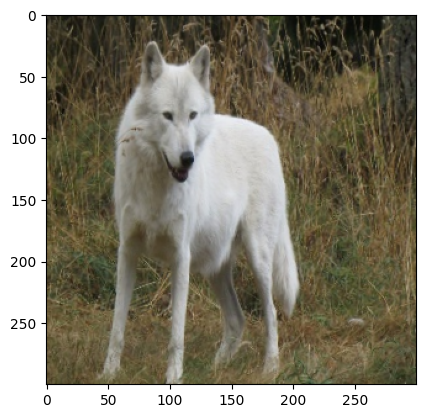

In [21]:
batch_images,batch_labels=next(train_generator)
index=0
plt.imshow(batch_images[index])
print(batch_labels[index])
print(np.max(batch_images))

In [2]:
def create_features_labels(data_path,n=300):
    husky_train=os.listdir(f'{data_path}/husky')
    wolf_train=os.listdir(f'{data_path}/wolf')
    # Create a random mix of husky and wolf images
    mixed_data = [(img, 0) for img in husky_train] + [(img, 1) for img in wolf_train]
    random.shuffle(mixed_data)

    # Separate features (X) and labels (Y)
    images_names = [item[0] for item in mixed_data]
    Y = np.array([item[1] for item in mixed_data])
    def husky_or_wolf(text):
        if "husky" in text:
            return "husky"
        else:
            return "wolf"


    X=np.array([ cv.resize(cv.imread(f"{data_path}/{husky_or_wolf(i)}/{i}"),(300,300))/255 for i in images_names[:n] ])
    return X,Y[:n]



In [5]:
X,Y=create_features_labels("data/train")
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2)
X,Y=[],[]

(300, 300, 3)
1
1.0


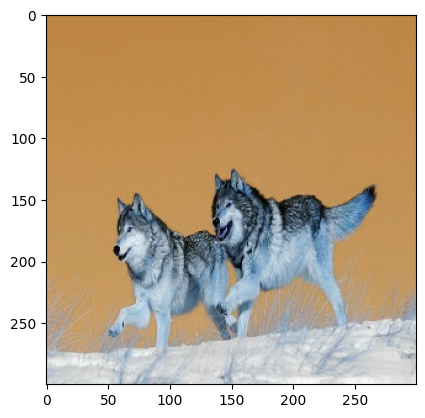

In [17]:
index=6
print(X_train[index].shape)
plt.imshow(X_train[index])
print(Y_train[index])
print(np.max(X_train))


In [ ]:
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(300, 300,3)),
    keras.layers.Conv2D(32, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.0001)),
    keras.layers.MaxPooling2D((2, 2),strides=2),

    keras.layers.Conv2D(64, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.0001)),
    keras.layers.MaxPooling2D((2, 2),strides=2),

    keras.layers.Conv2D(64, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.0001)),
 
    keras.layers.MaxPooling2D((2, 2),strides=2),

    keras.layers.Conv2D(128, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.0001)),

    keras.layers.MaxPooling2D((2, 2),strides=2),



    keras.layers.Conv2D(256, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.0001)),




 

    keras.layers.MaxPooling2D((2, 2),strides=2),





    keras.layers.Flatten(),
    keras.layers.Dense(1000, activation='relu',kernel_regularizer=regularizers.l2(0.0001)),

    keras.layers.Dense(1000, activation='relu',kernel_regularizer=regularizers.l2(0.0001)),


    keras.layers.Dense(50, activation='relu',kernel_regularizer=regularizers.l2(0.0001)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1),



    keras.layers.Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 149, 149, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 147, 147, 64)      18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 73, 73, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 71, 71, 64)        36928     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 35, 35, 64)       

In [13]:
from tensorflow.keras.applications import MobileNetV2

# Build the model
base_model = MobileNetV2(input_shape=(300, 300, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False  # Freeze base

model = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='sigmoid')  # Binary classifier
])

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 10, 10, 1280)      2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_3  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 128)               163968    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2422081 (9.24 MB)
Trainable params: 1640

In [22]:
callback=keras.callbacks.EarlyStopping(monitor="loss",patience=10)

model.fit(train_generator,validation_data=val_generator,epochs=100,callbacks=callback)

Epoch 1/100


2025-05-13 06:30:43.171432: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 276480000 exceeds 10% of free system memory.
2025-05-13 06:30:43.319062: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 280178688 exceeds 10% of free system memory.


 1/23 [>.............................] - ETA: 2:35 - loss: 0.6657 - accuracy: 0.6250

2025-05-13 06:30:45.935842: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 276480000 exceeds 10% of free system memory.
2025-05-13 06:30:46.093452: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 280178688 exceeds 10% of free system memory.


 2/23 [=>............................] - ETA: 50s - loss: 0.6895 - accuracy: 0.5781 

2025-05-13 06:30:48.294129: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 276480000 exceeds 10% of free system memory.


23/23 [==============================] - 81s 3s/step - loss: 0.6193 - accuracy: 0.6698 - val_loss: 0.5661 - val_accuracy: 0.7778
Epoch 2/100
23/23 [==============================] - 73s 3s/step - loss: 0.4363 - accuracy: 0.8649 - val_loss: 0.4326 - val_accuracy: 0.8519
Epoch 3/100
23/23 [==============================] - 71s 3s/step - loss: 0.3273 - accuracy: 0.9222 - val_loss: 0.3756 - val_accuracy: 0.8724
Epoch 4/100
23/23 [==============================] - 74s 3s/step - loss: 0.2575 - accuracy: 0.9277 - val_loss: 0.3555 - val_accuracy: 0.8477
Epoch 5/100
23/23 [==============================] - 73s 3s/step - loss: 0.2291 - accuracy: 0.9250 - val_loss: 0.3330 - val_accuracy: 0.8601
Epoch 6/100
23/23 [==============================] - 73s 3s/step - loss: 0.1929 - accuracy: 0.9454 - val_loss: 0.3849 - val_accuracy: 0.8560
Epoch 7/100
23/23 [==============================] - 46s 2s/step - loss: 0.1777 - accuracy: 0.9427 - val_loss: 0.3302 - val_accuracy: 0.8642
Epoch 8/100
23/23 [======

In [4]:
X_test,Y_test=create_features_labels('data/train')

In [6]:

model.evaluate(X_test,Y_test)
predictions=model.predict(X_test)>0.5
from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y_test,predictions))
X_test,Y_test=0,0

10/10 [==============================] - 21s 2s/step
[[120  17]
 [  2 161]]


In [ ]:
index=8
if model.predict(np.array([X_test[index]]))>0.5:
    print("wolf")
else:
    print("husky")
print(Y_test[index])

IndexError: index 8 is out of bounds for axis 0 with size 8

In [25]:
model.save("wolf_husky_classifier")

INFO:tensorflow:Assets written to: wolf_husky_classifier/assets


INFO:tensorflow:Assets written to: wolf_husky_classifier/assets


In [5]:
from tensorflow.keras.models import load_model
model=load_model("wolf_husky_classifier")


In [ ]:
predictions=model_load.predict(X_test)>0.5
for p,r in zip(predictions,Y_test):
    print(p,r)

1/1 [==============================] - 1s 1s/step
[ True] 0
[ True] 1
[ True] 1
[False] 0
[ True] 1
[False] 0
[False] 0
[ True] 0
[ True] 1
[ True] 0
[False] 0
[ True] 1
[False] 0
[False] 0
[False] 0
[ True] 1
[False] 0
[ True] 1
[ True] 1
[ True] 1
[False] 0


In [13]:
from tensorflow.keras.models import load_model

class WolfHuskyClassifier:
    def __init__(self):
        self.model=load_model("wolf_husky_classifier")
    def predict_file(self,filename):
        img=cv.resize(cv.imread(filename),(200,200))
        prediction=self.model.predict(np.array([img]))
        print(prediction.tolist(),"here")
        if prediction[0]>0.5:
            return "wolf"
        else:
            return "husky"


        

In [14]:
load_model=WolfHuskyClassifier()

In [ ]:

path="data/test internet/husky/husky_at_home_7.jpg"
print(load_model.predict_file(path))
img=cv.imread(path)
plt.imshow(img)


[ WARN:0@52.749] global loadsave.cpp:268 findDecoder imread_('data/test internet/husky/husky_at_home_7.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [3]:
X,Y=create_features_labels("data/train")

load_model.model.evaluate(X,Y)

X_test,Y_test=create_features_labels('data/test internet')

load_model.model.evaluate(X_test,Y_test)
plt.imshow(X[1])

NameError: name 'load_model' is not defined

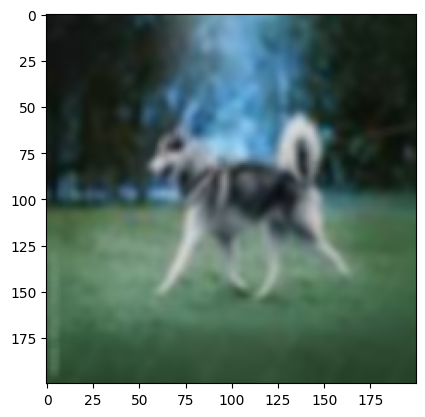

In [ ]:
X_blurred=np.array([cv.blur(img,(5,5)) for img in X])
plt.imshow(X_blurred[0])


In [ ]:

load_model.model.fit(X,Y,epochs=5)

Epoch 1/5
3/3 [==============================] - 6s 1s/step - loss: 0.4241 - accuracy: 0.8375
Epoch 2/5
3/3 [==============================] - 4s 988ms/step - loss: 0.3476 - accuracy: 0.9375
Epoch 3/5
3/3 [==============================] - 3s 781ms/step - loss: 0.2772 - accuracy: 0.9500
Epoch 4/5
3/3 [==============================] - 2s 620ms/step - loss: 0.2270 - accuracy: 0.9125
Epoch 5/5
3/3 [==============================] - 3s 778ms/step - loss: 0.1830 - accuracy: 0.9625


In [ ]:
load_model.model.save("wolf_husky_classifier")

INFO:tensorflow:Assets written to: wolf_husky_classifier/assets


INFO:tensorflow:Assets written to: wolf_husky_classifier/assets
